# 1. 데이터 로드 및 확인

In [1]:
from google.colab import drive
drive.mount('/content/drive/')
path = '/content/drive/MyDrive/DL/개인공부/jena_climate'

Mounted at /content/drive/


In [2]:
import os

fname = os.path.join(path, 'jena_climate_2009_2016.csv')
f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


- 420,451 x 15 크기의 데이터
- 420,451개의 타임스텝
- 1개의 날짜 변수(Date Time)와 14개의 날씨 정보 변수

In [3]:
example_line = lines[0]
print(example_line)

example_split = example_line.split(',')[1:]
print(example_split)

example_dtype = type(example_split[0])
print(example_dtype)

01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.30
['996.52', '-8.02', '265.40', '-8.90', '93.30', '3.33', '3.11', '0.22', '1.94', '3.12', '1307.75', '1.03', '1.75', '152.30']
<class 'str'>


데이터를 Numpy array로 변환하기 위해 해야할 일
1. 한 line 씩 읽어 날씨 정보에 해당하는 값인 1번 인덱스부터 끝까지 추출
2. 날씨 정보가 원래 float 형이나 현재 str 형이므로 float 값으로 변환
3. float형 날씨 정보로 구성되어있으며 크기는 14인 리스트를 420,451개 만들어 numpy array로 저장

In [4]:
# 전체 데이터를 numpy array로 변환
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))  # 420,451개의 행 x 14개의 날씨 정보 변수
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

In [5]:
# 변환된 데이터 확인
print(f"한 line당 크기: {len(float_data[0])}")
print(f"numpy array 변환 전 값: {lines[0].split(',')[1:]}")
print(f"numpy array 변환 후 값: {[np.round(i, 2) for i in float_data[0]]}")

한 line당 크기: 14
numpy array 변환 전 값: ['996.52', '-8.02', '265.40', '-8.90', '93.30', '3.33', '3.11', '0.22', '1.94', '3.12', '1307.75', '1.03', '1.75', '152.30']
numpy array 변환 후 값: [996.52, -8.02, 265.4, -8.9, 93.3, 3.33, 3.11, 0.22, 1.94, 3.12, 1307.75, 1.03, 1.75, 152.3]


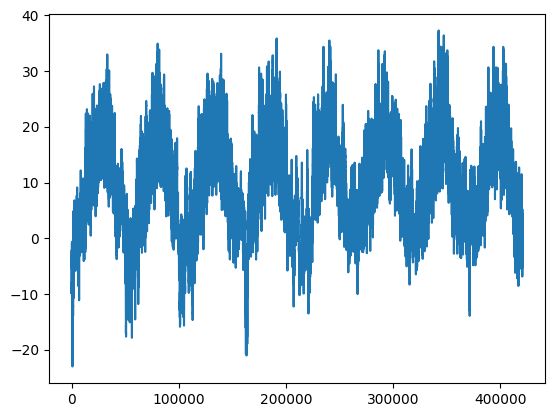

In [6]:
# 시계열 온도 그래프 그리기
import matplotlib.pyplot as plt

temp = float_data[:, 1] # 1번 컬럼이 섭씨 온도 값
plt.plot(range(len(temp)), temp)
plt.show()

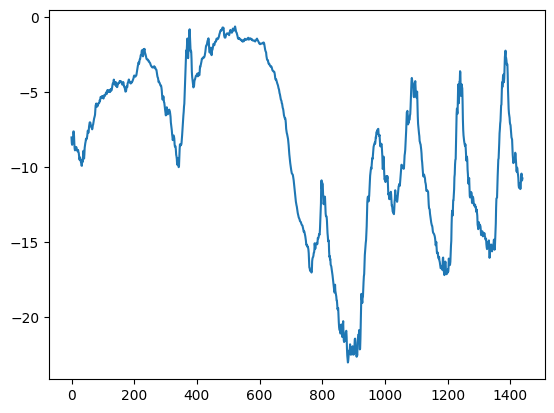

In [7]:
# 10일 간 온도 그래프
plt.plot(range(1440), temp[:1440]) # 하나의 행은 10분 단위의 값. 따라서 하루는 24 * 6 = 144행 씩. 144행이 10개, 즉 1440개의 행은 10일간의 기록
plt.show()

- 10일 모두 영하의 온도
- 4일부터 온도가 급격히 떨어지고 6일차에 최저 온도를 찍고는 다시 올라 영하 5도 ~ 영하 17도 부근을 왔다갔다 함.

지난 몇 달간 데이터를 사용하여 다음 달의 평균 온도를 예측하는 것은 쉬운 편! 하지만 하루하루 데이터를 살펴보면 온도 변화가 매우 불안정.

일자별 수준의 시계열 데이터를 예측할 수 있을까?

# 2. 데이터 전처리

시계열 예측을 위한 데이터 전처리
- lookback: 10일 전 (1440행 전)
- steps: 6 (1시간마다 데이터 포인트 샘플링)
- delay: 144 (24시간 후 데이터가 target)

필요한 두 가지 작업
- 신경망에 주입할 수 있는 형태로 데이터 전처리하기.
    - 데이터가 이미 수치형이므로 추가적인 벡터화는 필요하지 않으나 각 시계열 특성의 범위가 다르므로 "정규화"하기
- float_data 배열을 받아 과거 데이터의 배치와 미래 타깃 온도를 추출하는 generator 함수 만들기.
    - 데이터가 10분 간의 타임스텝으로 이루어져 있으므로 중복이 많다. --> 모든 샘플을 각기 메모리에 저장하는 것은 낭비가 심하므로 대신 원본 데이터를 사용하여 그때그때 배치를 만들기.

In [8]:
# 정규화
# 정규화 방식: (x - mean) / std
# train : valid : test = 200,000 : 100,000 : 120,451
mean = float_data[:200000].mean(axis=0)
float_data = float_data - mean
std = float_data[:200000].std(axis=0)
float_data = float_data / std

In [9]:
'''generator
    반환: (samples, targets)
        - (x, y) 튜플
        - 반복적 반환을 위해 return 아닌 yield
    매개변수
        - data: 정규화한 부동 소수 데이터로 이루어진 원본 배열
        - lookback: 거슬러 올라갈 타임스텝
        - delay: target으로 사용할 미래 타임스텝
        - min_index, max_index: 추출할 타임스텝의 범위를 지정하기 위한 data 배열 인덱스. 검증 데이터와 테스트 데이터 분리에 사용
        - shuffle: 샘플을 섞을지, 시간 순서대로 추출할 지 결정
        - batch_size: 배치의 샘플 수
        - step: 데이터를 샘플링할 타임스텝 간격. 1시간에 하나의 데이터 포인트를 추출하기 위해 6으로 지정
'''

def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [10]:
# train, validation, test generator
lookback = 1440
step = 6
delay = 144
batch_size = 128
train_gen = generator(float_data, lookback, delay, 0, 200000, shuffle=True)
val_gen = generator(float_data, lookback, delay, 200001, 300000)
test_gen = generator(float_data, lookback, delay, 300001, None)

val_steps = (300000 - 200001 - lookback) // batch_size # validation data를 순회하기 위해 val_gen에서 추출할 횟수
test_steps = (len(float_data) - 300001 - lookback) // batch_size # test data를 순회하기 위해 test_gen에서 추출할 횟수

# 3. 기준점

시계열 온도 데이터는 연속성이 있고 일자별로 주기성을 가진다고 볼 수 있다. (사실 이 데이터는 모델링하기 좋게 만들어진 데이터긴 하지만,  실제로는 데이터를 열어서 그래프를 그려보며 확인할 필요성이 있다. 이것도 GRU를 사용하여 모델링할 때 확인해보겠다.)
따라서 상식 수준의 기준점은 현재와 24시간 후 온도는 동일하다고 예측을 하는 것이다. 이 방법을 Mean Absolute Error(수치 예측 평가 기준)로 평가해보겠다.

### **적어도 현재와 24시간 후 온도가 동일하다고 예측한 MAE 보다는 딥러닝 모델을 이용한 예측 MAE가 더 낮아야 의미가 있다!**

In [11]:
# Mean Absolute Error 계산
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    res = np.mean(batch_maes)
    return res

In [12]:
standard_mae = evaluate_naive_method()
print(standard_mae)

0.2897359729905486


In [13]:
# 섭씨 온도 기준 계산: mae * 표준 편차
print(standard_mae * std[1])

2.564887434980494


온도 오차가 섭씨 2.56도 정도 나 오차가 상당히 크다.

# 4. GRU

In [14]:
from keras.models import Sequential
from keras.layers import GRU, Dense
from keras.optimizers import RMSprop

model = Sequential()
model.add(GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
hist = model.fit_generator(train_gen, steps_per_epoch=500, epochs=40, validation_data=val_gen, validation_steps=val_steps)

Epoch 1/40


<ipython-input-14-d0a0909c42c2>:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(train_gen, steps_per_epoch=500, epochs=40, validation_data=val_gen, validation_steps=val_steps)


500/500 [==============================] - 16s 28ms/step - loss: 0.3057 - val_loss: 0.2697
Epoch 2/40
500/500 [==============================] - 18s 36ms/step - loss: 0.2830 - val_loss: 0.2651
Epoch 3/40
500/500 [==============================] - 15s 29ms/step - loss: 0.2780 - val_loss: 0.2639
Epoch 4/40
500/500 [==============================] - 17s 33ms/step - loss: 0.2739 - val_loss: 0.2603
Epoch 5/40
500/500 [==============================] - 18s 35ms/step - loss: 0.2681 - val_loss: 0.2650
Epoch 6/40
500/500 [==============================] - 17s 33ms/step - loss: 0.2649 - val_loss: 0.2580
Epoch 7/40
500/500 [==============================] - 17s 35ms/step - loss: 0.2602 - val_loss: 0.2657
Epoch 8/40
500/500 [==============================] - 14s 27ms/step - loss: 0.2567 - val_loss: 0.2633
Epoch 9/40
500/500 [==============================] - 14s 28ms/step - loss: 0.2525 - val_loss: 0.2642
Epoch 10/40
500/500 [==============================] - 14s 28ms/step - loss: 0.2496 - val_los

# 5. Bidirectional GRU

In [15]:
from keras.layers import Bidirectional

model_bid = Sequential()
model_bid.add(Bidirectional(GRU(32), input_shape=(None, float_data.shape[-1])))
model_bid.add(Dense(1))
model_bid.compile(optimizer=RMSprop(), loss='mae')
hist_bid = model_bid.fit_generator(train_gen, steps_per_epoch=500, epochs=40, validation_data=val_gen, validation_steps=val_steps)

Epoch 1/40


<ipython-input-15-e956db656485>:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist_bid = model_bid.fit_generator(train_gen, steps_per_epoch=500, epochs=40, validation_data=val_gen, validation_steps=val_steps)


500/500 [==============================] - 23s 40ms/step - loss: 0.3074 - val_loss: 0.2702
Epoch 2/40
500/500 [==============================] - 18s 36ms/step - loss: 0.2786 - val_loss: 0.2653
Epoch 3/40
500/500 [==============================] - 21s 42ms/step - loss: 0.2710 - val_loss: 0.2674
Epoch 4/40
500/500 [==============================] - 18s 36ms/step - loss: 0.2662 - val_loss: 0.2710
Epoch 5/40
500/500 [==============================] - 19s 38ms/step - loss: 0.2613 - val_loss: 0.2686
Epoch 6/40
500/500 [==============================] - 18s 36ms/step - loss: 0.2578 - val_loss: 0.2629
Epoch 7/40
500/500 [==============================] - 18s 37ms/step - loss: 0.2518 - val_loss: 0.2737
Epoch 8/40
500/500 [==============================] - 20s 40ms/step - loss: 0.2449 - val_loss: 0.2789
Epoch 9/40
500/500 [==============================] - 18s 36ms/step - loss: 0.2397 - val_loss: 0.2829
Epoch 10/40
500/500 [==============================] - 19s 38ms/step - loss: 0.2349 - val_los

# 6. 그래프

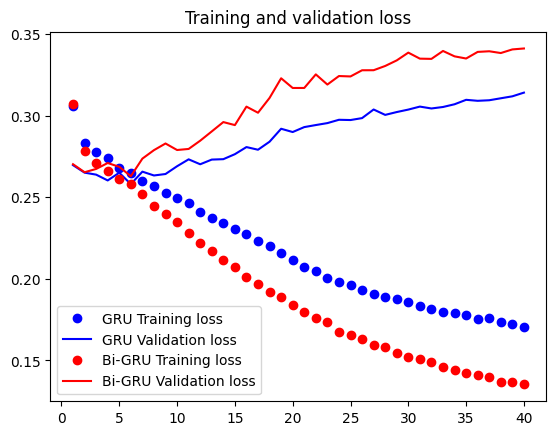

In [16]:
import matplotlib.pyplot as plt

epochs = range(1, 41)

history = hist.history
loss = history['loss']
val_loss = history['val_loss']

history_bid = hist_bid.history
loss_bid = history_bid['loss']
val_loss_bid = history_bid['val_loss']

plt.plot(epochs, loss, 'bo', label='GRU Training loss')
plt.plot(epochs, val_loss, 'b', label='GRU Validation loss')
plt.plot(epochs, loss_bid, 'ro', label='Bi-GRU Training loss')
plt.plot(epochs, val_loss_bid, 'r', label='Bi-GRU Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# 7. 성능

In [39]:
y_pred = model.predict_generator(test_gen, steps=test_steps)
y_test = float_data[:, 1][300001:300001+len(pred)]

<ipython-input-39-3291f3af40ee>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = model.predict_generator(test_gen, steps=test_steps)


In [40]:
y_pred_bid = model_bid.predict_generator(test_gen, steps=test_steps)

<ipython-input-40-778bad1bb001>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred_bid = model_bid.predict_generator(test_gen, steps=test_steps)


In [41]:
from sklearn.metrics import mean_absolute_error

print(f"GRU: {mean_absolute_error(y_test, y_pred)}")
print(f"Bi-GRU: {mean_absolute_error(y_test, y_pred_bid)}")

GRU: 0.6557845382864063
Bi-GRU: 0.6702906587484468


- 온도 예측 시 양방향 GRU를 사용했을 때보다 일반 GRU를 사용했을 때, 테스트 데이터에 대해 MAE 값이 조금 더 낮다.

- 온도 예측 문제의 경우 시간 순서가 매우 중요하다. 양방향 GRU는 일반 GRU와 달리 시간 순서와 **시간 반대 순서**를 모두 이용하므로 성능이 더 낮게 나온다. 따라서 온도 예측 문제같이 최근 정보가 오래 전 정보보다 훨씬 더 중요한 경우와 언어 이해와 같이 시간 순서도 중요하지만 결정적이지 않은 경우에 따라 모델을 설계해야 한다.